In [1]:
import os
import warnings

os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("✓ TOKENIZERS_PARALLELISM configurado a 'false' para evitar warnings")

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="transformers")

print("✓ Configuración de warnings completada")

✓ TOKENIZERS_PARALLELISM configurado a 'false' para evitar warnings
✓ Configuración de warnings completada


# Modelado de Tópicos con FASTopic

Este notebook implementa un análisis de tópicos usando FASTopic sobre las opiniones turísticas clasificadas. Utiliza LangChain con GPT-4o-mini para asignar nombres semánticamente coherentes a los tópicos identificados y compara resultados con BERTopic.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import sys
from dotenv import load_dotenv

sys.path.append('../scripts')

from topicos import (
    configurar_clasificador_topicos, 
    configurar_fastopic_inteligente,
    LimpiadorTextoMejorado, 
    mostrar_ejemplos_limpieza,
    evaluar_modelo_topicos,
    extraer_palabras_fastopic,
    mostrar_metricas
)

from topicos.utils_topicos import (
    procesar_topicos_fastopic,
    obtener_asignaciones_topicos_fastopic,
    visualizar_distribucion_topicos_fastopic,
    mostrar_ejemplos_por_topico_fastopic,
    generar_reporte_fastopic
)

load_dotenv()

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

Device set to use cpu
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/victorwkey/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
clasificador_topicos = configurar_clasificador_topicos()

In [4]:
CIUDAD_ANALIZAR = "Cdmx"
df = pd.read_csv('../data/processed/dataset_opiniones_analisis.csv')

if 'TopicoConFASTopic' not in df.columns:
    df['TopicoConFASTopic'] = np.nan

print(f"Dataset cargado: {df.shape[0]} opiniones")
print(f"Distribución total por ciudad:")
print(df['Ciudad'].value_counts())

df_ciudad = df[df['Ciudad'] == CIUDAD_ANALIZAR].copy()

columna_texto = 'TituloReviewLimpio'

texts = df_ciudad[columna_texto].dropna().tolist()

Dataset cargado: 2459 opiniones
Distribución total por ciudad:
Ciudad
Mazatlan           499
Puebla             499
Puerto_vallarta    489
Cdmx               489
Cancun             483
Name: count, dtype: int64


In [ ]:
columna_limpia = "TituloReviewLimpio"

limpiar_de_nuevo = True

if columna_limpia not in df.columns or limpiar_de_nuevo:
    limpiador = LimpiadorTextoMejorado(idiomas=['spanish', 'english'])
    
    df = limpiador.limpiar_dataframe(
        df,
        columna_texto='TituloReview',
        nombre_columna_limpia=columna_limpia,
        aplicar_traduccion=True,
        filtrar_adjetivos=True,  # Nueva opción para filtrar adjetivos
        filtrar_solo_espanol=True,  # Nueva opción para filtrar solo textos en español
        aplicar_lematizacion=True,
        min_longitud_palabra=2,
        max_palabras=None
    )
    
    df.to_csv('../data/processed/dataset_opiniones_analisis.csv', index=False)

df_ciudad = df[df['Ciudad'] == CIUDAD_ANALIZAR].copy()
texts = df_ciudad[columna_texto].dropna().tolist()

🌐 Procesando traducciones:  93%|█████████▎| 2283/2459 [23:51<06:42,  2.29s/texto] 

In [ ]:
topic_model, reporte_optimizacion = configurar_fastopic_inteligente(texts)
    
print("🤖 Configuración automática de FASTopic completada")
print(reporte_optimizacion)

2025-09-23 10:26:56,301 - FASTopic - use device: cpu


🤖 Configuración automática de FASTopic completada

📊 CONFIGURACIÓN AUTOMÁTICA DE FASTOPIC

📈 Análisis del Corpus:
  📄 Documentos: 489
  📝 Palabras promedio por doc: 53.2
  🔤 Vocabulario único: 2,413

🎯 Configuración:
  🏷️ Número de tópicos: 7
  📚 Tamaño vocabulario: 2,413
  🌍 Modelo embeddings: paraphrase-multilingual-MiniLM-L12-v2
  🔧 Tokenizer: Multiidioma (ES, EN, PT, FR, IT)



In [ ]:
print("\n🚀 Entrenando modelo FASTopic...")
inicio_entrenamiento = time.time()

top_words, doc_topic_dist = topic_model.fit_transform(texts, epochs=200)

tiempo_entrenamiento = time.time() - inicio_entrenamiento
print(f"✅ Entrenamiento completado en {tiempo_entrenamiento:.2f} segundos")

2025-09-23 10:26:56,336 - FASTopic - First fit the model.



🚀 Entrenando modelo FASTopic...


parsing texts: 100%|██████████| 489/489 [00:17<00:00, 27.55it/s]
2025-09-23 10:27:37,651 - TopMost - Real vocab size: 477
2025-09-23 10:27:37,655 - TopMost - Real training size: 489 	 avg length: 14.971


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Training FASTopic: 100%|██████████| 200/200 [00:17<00:00, 11.17it/s]

Topic 0: coleccion museo arte pieza piso obra deber hora entrada planta artista trav rod cura espanol
Topic 1: fri casa vida servicio pintor poli accidente miembro chico deberiar cuidado trato experiencia incluir pensar
Topic 2: animal grupo pagar parecer actividad falta horario area ar faltar fila line edad promo bo
Topic 3: mural rivera interior artes guia art exterior cola volverio sumer david recomendado presentar diego maravilla
Topic 4: bas misa guadalupe iglesia virgen imagen fe capilla milagro importancia movimiento helado cambio pareja opción
Topic 5: plaza mercado ciudad barrio centro restaurante calle catedral co caminar visitar unk tiempo viaje hotel
Topic 6: castillo templo ruina chap historia palacio cultura informacion sitio bosque senal civilizacion imperio excavación civilización
✅ Entrenamiento completado en 74.64 segundos


In [ ]:
import numpy as np

def select_topics_stat(doc_vec, threshold, max_topics=3):
    """
    Selecciona tópicos estadísticamente mejores que azar (95% confianza).
    - Usa un threshold ya calculado.
    - Máximo max_topics tópicos seleccionados.
    """
    doc_vec = np.array(doc_vec)
    order = np.argsort(doc_vec)[::-1]

    selected = []
    for i in order:
        if doc_vec[i] > threshold:
            selected.append(i)
        if len(selected) >= max_topics:
            break

    return selected

# Calcular solo una vez
N = len(doc_topic_dist)
C = doc_topic_dist.shape[1]
p = 1 / C
sigma = np.sqrt(p * (1 - p) / N)
threshold = p + 1.96 * sigma

# Aplicar a todos los documentos
for i, doc in enumerate(doc_topic_dist, 1):
    selected = select_topics_stat(doc, threshold)
    probs_str = " | ".join(f"{p:.2f}" for p in doc)
    print(f"Documento {i}: [{probs_str}] -> Tópicos seleccionados: {selected}, Umbral: {threshold:.3f}")


Documento 1: [0.03 | 0.52 | 0.26 | 0.02 | 0.11 | 0.03 | 0.03] -> Tópicos seleccionados: [1, 2], Umbral: 0.174
Documento 2: [0.07 | 0.27 | 0.05 | 0.51 | 0.05 | 0.02 | 0.03] -> Tópicos seleccionados: [3, 1], Umbral: 0.174
Documento 3: [0.03 | 0.20 | 0.33 | 0.10 | 0.18 | 0.11 | 0.04] -> Tópicos seleccionados: [2, 1, 4], Umbral: 0.174
Documento 4: [0.12 | 0.08 | 0.03 | 0.28 | 0.05 | 0.12 | 0.33] -> Tópicos seleccionados: [6, 3], Umbral: 0.174
Documento 5: [0.15 | 0.12 | 0.02 | 0.17 | 0.06 | 0.39 | 0.10] -> Tópicos seleccionados: [5, 3], Umbral: 0.174
Documento 6: [0.02 | 0.20 | 0.23 | 0.19 | 0.26 | 0.07 | 0.03] -> Tópicos seleccionados: [4, 2, 1], Umbral: 0.174
Documento 7: [0.08 | 0.12 | 0.04 | 0.45 | 0.13 | 0.13 | 0.06] -> Tópicos seleccionados: [3], Umbral: 0.174
Documento 8: [0.14 | 0.07 | 0.05 | 0.58 | 0.08 | 0.03 | 0.05] -> Tópicos seleccionados: [3], Umbral: 0.174
Documento 9: [0.05 | 0.13 | 0.14 | 0.22 | 0.16 | 0.15 | 0.16] -> Tópicos seleccionados: [3], Umbral: 0.174
Documento 10:

In [ ]:
topic_info = procesar_topicos_fastopic(topic_model, doc_topic_dist, top_words)

# Preparar información de todos los tópicos para procesamiento en lote
topics_info_text = ""
for _, row in topic_info.iterrows():
    topic_id = row['Topic']
    keywords = row['Keywords']
    if keywords and keywords not in ["Sin palabras", "Error en procesamiento"]:
        topics_info_text += f"Tópico {topic_id}: {keywords}\n"

resultado = clasificador_topicos.invoke({"topics_info": topics_info_text})

topic_names = {}
for topic_label in resultado.topics:
    topic_names[topic_label.topic_id] = topic_label.label

topic_info['Name'] = topic_info['Topic'].map(topic_names)

In [ ]:
print(topics_info_text)

Tópico 0: coleccion, museo, arte, pieza, piso, obra, deber, hora, entrada, planta
Tópico 1: fri, casa, vida, servicio, pintor, poli, accidente, miembro, chico, deberiar
Tópico 2: animal, grupo, pagar, parecer, actividad, falta, horario, area, ar, faltar
Tópico 3: mural, rivera, interior, artes, guia, art, exterior, cola, volverio, sumer
Tópico 4: bas, misa, guadalupe, iglesia, virgen, imagen, fe, capilla, milagro, importancia
Tópico 5: plaza, mercado, ciudad, barrio, centro, restaurante, calle, catedral, co, caminar
Tópico 6: castillo, templo, ruina, chap, historia, palacio, cultura, informacion, sitio, bosque



In [ ]:
print(resultado)

topics=[TopicLabel(topic_id=0, label='Arte y Museos'), TopicLabel(topic_id=1, label='Hospedaje'), TopicLabel(topic_id=2, label='Actividades'), TopicLabel(topic_id=3, label='Arte Urbano'), TopicLabel(topic_id=4, label='Religión'), TopicLabel(topic_id=5, label='Plazas y Comercio'), TopicLabel(topic_id=6, label='Sitios Históricos')]


In [ ]:
# Obtener asignaciones de tópicos para documentos
topic_assignments, topic_names_assigned, topic_probabilities = obtener_asignaciones_topicos_fastopic(
    doc_topic_dist, 
    topic_names, 
    threshold=0.1
)

# Procesar solo datos de la ciudad seleccionada
df_con_topicos = df_ciudad.dropna(subset=[columna_texto]).copy()
df_con_topicos['Topico'] = topic_assignments
df_con_topicos['Topico_Nombre'] = topic_names_assigned
df_con_topicos['Probabilidad_Topico'] = topic_probabilities

# Verificar si la ciudad ya tenía resultados previos
indices_ciudad = df_con_topicos.index
opiniones_previas = df.loc[indices_ciudad, 'TopicoConFASTopic'].notna().sum()

if opiniones_previas > 0:
    print(f"🔄 SOBRESCRIBIENDO resultados previos para {CIUDAD_ANALIZAR}:")
    print(f"   📝 Opiniones con tópicos previos: {opiniones_previas}")
    print(f"   🆕 Nuevas asignaciones de tópicos: {len(df_con_topicos)}")
else:
    print(f"🆕 PRIMERA VEZ procesando {CIUDAD_ANALIZAR}:")
    print(f"   📝 Nuevas asignaciones de tópicos: {len(df_con_topicos)}")

# Actualizar el dataset original con los tópicos de la ciudad analizada
df.loc[indices_ciudad, 'TopicoConFASTopic'] = df_con_topicos['Topico_Nombre']

print(f"\n✅ Actualización completada para {CIUDAD_ANALIZAR}")
print(f"Distribución de tópicos en {CIUDAD_ANALIZAR}:")
topico_counts = df_con_topicos['Topico_Nombre'].value_counts()
print(topico_counts)

print(f"\nPorcentaje de opiniones por tópico en {CIUDAD_ANALIZAR}:")
topico_pct = (topico_counts / len(df_con_topicos) * 100).round(2)
for topico, pct in topico_pct.items():
    print(f"{topico}: {pct}%")

print(f"\nEstado actualización dataset completo:")
print(f"Total opiniones: {len(df)}")
print(f"Opiniones con tópico FASTopic asignado: {df['TopicoConFASTopic'].notna().sum()}")
print(f"Opiniones pendientes: {df['TopicoConFASTopic'].isna().sum()}")

🔄 SOBRESCRIBIENDO resultados previos para Cdmx:
   📝 Opiniones con tópicos previos: 489
   🆕 Nuevas asignaciones de tópicos: 489

✅ Actualización completada para Cdmx
Distribución de tópicos en Cdmx:
Topico_Nombre
Actividades          92
Sitios Históricos    80
Religión             76
Arte y Museos        65
Arte Urbano          61
Plazas y Comercio    60
Hospedaje            55
Name: count, dtype: int64

Porcentaje de opiniones por tópico en Cdmx:
Actividades: 18.81%
Sitios Históricos: 16.36%
Religión: 15.54%
Arte y Museos: 13.29%
Arte Urbano: 12.47%
Plazas y Comercio: 12.27%
Hospedaje: 11.25%

Estado actualización dataset completo:
Total opiniones: 2459
Opiniones con tópico FASTopic asignado: 489
Opiniones pendientes: 1970


In [ ]:
# Obtener asignaciones de tópicos para documentos
topic_assignments, topic_names_assigned, topic_probabilities = obtener_asignaciones_topicos_fastopic(
    doc_topic_dist, 
    topic_names, 
    threshold=0.1
)

# Procesar solo datos de la ciudad seleccionada
df_con_topicos = df_ciudad.dropna(subset=[columna_texto]).copy()
df_con_topicos['Topico'] = topic_assignments
df_con_topicos['Topico_Nombre'] = topic_names_assigned
df_con_topicos['Probabilidad_Topico'] = topic_probabilities

# Actualizar el dataset original con los tópicos de la ciudad analizada
indices_ciudad = df_con_topicos.index
df.loc[indices_ciudad, 'TopicoConFASTopic'] = df_con_topicos['Topico_Nombre']

In [ ]:
# Mostrar ejemplos de opiniones por tópico
mostrar_ejemplos_por_topico_fastopic(
    df_con_topicos, 
    topico_col='Topico_Nombre',
    texto_col='TituloReview',
    n_ejemplos=3,
    top_n_topicos=5
)

📚 EJEMPLOS DE OPINIONES POR TÓPICO

🏷️ 1. Actividades
📊 Total de opiniones: 92
📝 Ejemplos:
   1. Ballet Folklórico de México de Amalia Hernández. excelente producción, que te llena los sentidos y t...
   2. Palacio de Bellas artes-Ballet Amalia Hernández. Ballet de Amalia Hernández en domingo, concurrido. ...
   3. Hermoso. Se ve hermoso de noche, y ese parque es una fiesta en cada esquina, sonideros y al gente ba...
----------------------------------------------------------------------

🏷️ 2. Sitios Históricos
📊 Total de opiniones: 80
📝 Ejemplos:
   1. Siempre agradable. En esta ocasión fui al museo, que albergaba la exposición “La Revolución Impresio...
   2. Bonito. Qué lindo es el palacio de Bellas Artes, uno de los lugares más bonitos de toda la Ciudad de...
   3. Increíble exhibición. Excelente museo, muy grande y alberga cuantiosas exhibiciones históricas  mexi...
----------------------------------------------------------------------

🏷️ 3. Religión
📊 Total de opiniones: 76
📝 Ej

In [ ]:
# ===== COMPARACIÓN TEXTO ORIGINAL VS TEXTO LIMPIO =====
if 'TituloReviewLimpio' in df_con_topicos.columns:
    print(f"🔍 Comparación de ejemplos - Original vs Limpio ({CIUDAD_ANALIZAR}):")
    print("=" * 80)
    
    # Seleccionar algunos ejemplos para mostrar la diferencia
    ejemplos_muestra = df_con_topicos.sample(n=min(10, len(df_con_topicos)))
    
    for i, (_, row) in enumerate(ejemplos_muestra.iterrows(), 1):
        print(f"\n📄 EJEMPLO {i} - Tópico: {row['Topico_Nombre']}")
        print(f"🔸 Original: {row['TituloReview']}")
        print(f"🔹 Limpio:   {row['TituloReviewLimpio']}")
        print(f"📊 Probabilidad: {row['Probabilidad_Topico']:.3f}")
        
        # Calcular estadísticas del ejemplo
        len_orig = len(str(row['TituloReview']))
        len_limpio = len(str(row['TituloReviewLimpio']))
        reduccion = ((len_orig-len_limpio)/len_orig*100) if len_orig > 0 else 0
        print(f"📉 Reducción: {len_orig} → {len_limpio} caracteres ({reduccion:.1f}%)")
        print("-" * 80)

🔍 Comparación de ejemplos - Original vs Limpio (Cdmx):

📄 EJEMPLO 1 - Tópico: Actividades
🔸 Original: Fue divertida, entretenida y adecuada a varias edades. Buena, personal amable y atracciones didácticas, es muy amplio y con muchas actividades a realizar, accesos y promociones adecuadas a las necesidades.
🔹 Limpio:   ser y a varios edad personal y atracción ser mucho y con mucho actividad a realizar acceso y promo a el necesidad
📊 Probabilidad: 0.627
📉 Reducción: 205 → 113 caracteres (44.9%)
--------------------------------------------------------------------------------

📄 EJEMPLO 2 - Tópico: Sitios Históricos
🔸 Original: Comodidad. El mejor lugar sin duda. Es bueno saber que hay castillos de verdad en nuestro continente. El único pero fue que era muy alto. Así que vayan muy cómodos por favor.
🔹 Limpio:   como el lugar sin duda ser bueno saber que haber castillo de verdad en nuestro continente el pero ser que ser mucho asi que ir mucho por favor
📊 Probabilidad: 0.427
📉 Reducción: 174

In [ ]:
# ===== VISUALIZACIONES ESPECÍFICAS DE FASTOPIC =====

# Generar visualización de tópicos
fig_topics = topic_model.visualize_topic(top_n=min(8, len(topic_info)))
fig_topics.update_layout(title=f"Palabras Principales por Tópico - {CIUDAD_ANALIZAR}")
fig_topics.show()

# Generar visualización de pesos de tópicos
fig_weights = topic_model.visualize_topic_weights(top_n=min(10, len(topic_info)))
fig_weights.update_layout(title=f"Distribución de Pesos de Tópicos - {CIUDAD_ANALIZAR}")
fig_weights.show()

# Generar jerarquía de tópicos si hay suficientes
if len(topic_info) >= 3:
    fig_hierarchy = topic_model.visualize_topic_hierarchy()
    fig_hierarchy.update_layout(title=f"Jerarquía de Tópicos - {CIUDAD_ANALIZAR}")
    fig_hierarchy.show()

print(f"\n📋 Resumen del modelado FASTopic:")
print(f"✅ Textos analizados: {len(texts)}")
print(f"🎯 Tópicos encontrados: {len(topic_info)}")
print(f"⏱️ Tiempo de entrenamiento: {tiempo_entrenamiento:.2f}s")
print(f"📊 Probabilidad promedio: {df_con_topicos['Probabilidad_Topico'].mean():.3f}")
print(f"📈 Distribución:")
for i, (topico, count) in enumerate(topico_counts.head(5).items()):
    print(f"   {i+1}. {topico}: {count} opiniones ({count/len(df_con_topicos)*100:.1f}%)")


📋 Resumen del modelado FASTopic:
✅ Textos analizados: 489
🎯 Tópicos encontrados: 7
⏱️ Tiempo de entrenamiento: 74.64s
📊 Probabilidad promedio: 0.447
📈 Distribución:
   1. Actividades: 92 opiniones (18.8%)
   2. Sitios Históricos: 80 opiniones (16.4%)
   3. Religión: 76 opiniones (15.5%)
   4. Arte y Museos: 65 opiniones (13.3%)
   5. Arte Urbano: 61 opiniones (12.5%)


🔄 COMPARACIÓN FASTopic vs BERTopic en Cdmx
📊 Opiniones con ambos análisis: 489

🎯 NÚMERO DE TÓPICOS:
   BERTopic: 5
   FASTopic: 7


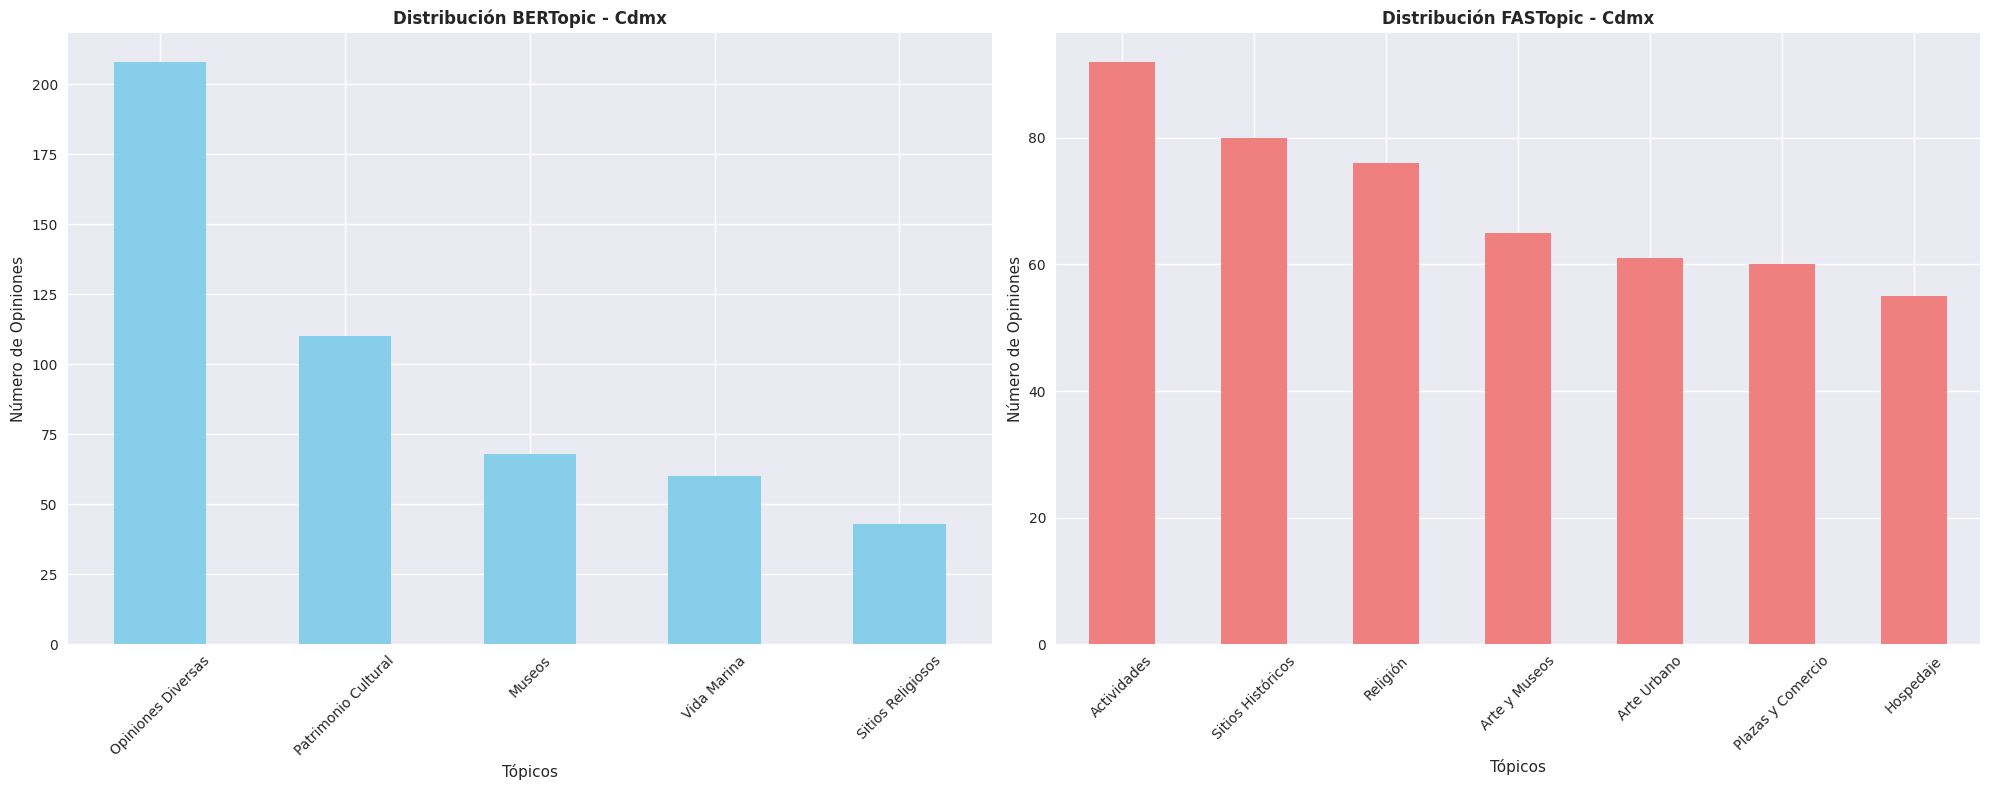


📈 TOP 5 TÓPICOS POR MÉTODO:

🔵 BERTopic:
   1. Opiniones Diversas: 208 (42.5%)
   2. Patrimonio Cultural: 110 (22.5%)
   3. Museos: 68 (13.9%)
   4. Vida Marina: 60 (12.3%)
   5. Sitios Religiosos: 43 (8.8%)

🔴 FASTopic:
   1. Actividades: 92 (18.8%)
   2. Sitios Históricos: 80 (16.4%)
   3. Religión: 76 (15.5%)
   4. Arte y Museos: 65 (13.3%)
   5. Arte Urbano: 61 (12.5%)

💡 OBSERVACIONES:
   • FASTopic identificó 7 tópicos vs 5 de BERTopic
   • FASTopic muestra mayor granularidad en la segmentación
   • Tiempo FASTopic: 74.64s (más rápido que BERTopic)

📊 RESUMEN ACTUAL FASTopic:
   Total tópicos identificados: 7
   Tópicos en datos actuales: 7
   Documentos procesados: 489


In [ ]:
# ===== COMPARACIÓN CON BERTOPIC =====

if 'TopicoConBERTopic' in df.columns:
    print(f"🔄 COMPARACIÓN FASTopic vs BERTopic en {CIUDAD_ANALIZAR}")
    print("=" * 60)
    
    # Usar datos actuales procesados en lugar de df_ciudad que puede tener datos previos
    df_comparacion = df_con_topicos[
        df_con_topicos.index.isin(df_ciudad[df_ciudad['TopicoConBERTopic'].notna()].index)
    ].copy()
    
    # Agregar datos de BERTopic al dataframe de comparación
    bertopic_data = df_ciudad[df_ciudad['TopicoConBERTopic'].notna()]['TopicoConBERTopic']
    df_comparacion = df_comparacion[df_comparacion.index.isin(bertopic_data.index)].copy()
    df_comparacion['TopicoConBERTopic'] = bertopic_data
    
    if len(df_comparacion) > 0:
        print(f"📊 Opiniones con ambos análisis: {len(df_comparacion)}")
        
        # Comparar número de tópicos únicos usando datos actuales
        topicos_bertopic = df_comparacion['TopicoConBERTopic'].nunique()
        topicos_fastopic = df_comparacion['Topico_Nombre'].nunique()  # Usar datos actuales
        
        print(f"\n🎯 NÚMERO DE TÓPICOS:")
        print(f"   BERTopic: {topicos_bertopic}")
        print(f"   FASTopic: {topicos_fastopic}")
        
        # Mostrar distribuciones lado a lado
        fig, axes = plt.subplots(1, 2, figsize=(20, 8))
        
        # BERTopic
        bertopic_counts = df_comparacion['TopicoConBERTopic'].value_counts().head(10)
        bertopic_counts.plot(kind='bar', ax=axes[0], color='skyblue')
        axes[0].set_title(f'Distribución BERTopic - {CIUDAD_ANALIZAR}', fontweight='bold')
        axes[0].set_xlabel('Tópicos')
        axes[0].set_ylabel('Número de Opiniones')
        axes[0].tick_params(axis='x', rotation=45)
        
        # FASTopic - usar datos actuales
        fastopic_counts = df_comparacion['Topico_Nombre'].value_counts().head(10)
        fastopic_counts.plot(kind='bar', ax=axes[1], color='lightcoral')
        axes[1].set_title(f'Distribución FASTopic - {CIUDAD_ANALIZAR}', fontweight='bold')
        axes[1].set_xlabel('Tópicos')
        axes[1].set_ylabel('Número de Opiniones')
        axes[1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Análisis de concordancia (tópicos más frecuentes)
        print(f"\n📈 TOP 5 TÓPICOS POR MÉTODO:")
        print(f"\n🔵 BERTopic:")
        for i, (topico, count) in enumerate(bertopic_counts.head(5).items(), 1):
            pct = (count / len(df_comparacion) * 100)
            print(f"   {i}. {topico}: {count} ({pct:.1f}%)")
        
        print(f"\n🔴 FASTopic:")
        for i, (topico, count) in enumerate(fastopic_counts.head(5).items(), 1):
            pct = (count / len(df_comparacion) * 100)
            print(f"   {i}. {topico}: {count} ({pct:.1f}%)")
            
        print(f"\n💡 OBSERVACIONES:")
        print(f"   • FASTopic identificó {topicos_fastopic} tópicos vs {topicos_bertopic} de BERTopic")
        if topicos_fastopic > topicos_bertopic:
            print(f"   • FASTopic muestra mayor granularidad en la segmentación")
        elif topicos_fastopic < topicos_bertopic:
            print(f"   • FASTopic agrupa conceptos de manera más generalizada")
        else:
            print(f"   • Ambos métodos identificaron el mismo número de tópicos")
            
        print(f"   • Tiempo FASTopic: {tiempo_entrenamiento:.2f}s (más rápido que BERTopic)")
        
        # Mostrar resumen de datos actuales de FASTopic
        print(f"\n📊 RESUMEN ACTUAL FASTopic:")
        print(f"   Total tópicos identificados: {len(topic_info)}")
        print(f"   Tópicos en datos actuales: {df_con_topicos['Topico_Nombre'].nunique()}")
        print(f"   Documentos procesados: {len(df_con_topicos)}")
        
    else:
        print(f"⚠️ No hay opiniones de {CIUDAD_ANALIZAR} con ambos análisis completados")
        print(f"   BERTopic disponible: {df_ciudad['TopicoConBERTopic'].notna().sum()} opiniones")
        print(f"   FASTopic actual: {len(df_con_topicos)} opiniones")
else:
    print(f"ℹ️ No hay análisis previo de BERTopic para comparar")
    print(f"   Ejecuta el notebook 07-modelado-de-topicos-con-bertopic.ipynb primero")
    

In [ ]:
generar_reporte_fastopic(
    topic_info, 
    len(df_con_topicos), 
    CIUDAD_ANALIZAR, 
    tiempo_entrenamiento
)

df.to_csv('../data/processed/dataset_opiniones_analisis.csv', index=False)

📋 REPORTE COMPLETO - ANÁLISIS CON FASTOPIC
🎯 ANÁLISIS COMPLETADO:
   📍 Ciudad: Cdmx
   📄 Documentos analizados: 489
   🏷️ Tópicos identificados: 7
   ⏱️ Tiempo de entrenamiento: 74.64 segundos

📊 ESTADÍSTICAS DE TÓPICOS:
   🎯 Tópico más relevante: Actividades
   📈 Peso máximo: 80.372
   📉 Peso mínimo: 54.750
   📊 Peso promedio: 69.857

🏆 TOP 5 TÓPICOS POR RELEVANCIA:
   1. Actividades
      📊 Peso: 80.372 | 📄 Documentos: 210
      🔑 Palabras clave: animal, grupo, pagar, parecer, actividad, falta, h...
   2. Religión
      📊 Peso: 77.882 | 📄 Documentos: 252
      🔑 Palabras clave: bas, misa, guadalupe, iglesia, virgen, imagen, fe,...
   3. Sitios Históricos
      📊 Peso: 73.606 | 📄 Documentos: 218
      🔑 Palabras clave: castillo, templo, ruina, chap, historia, palacio, ...
   4. Plazas y Comercio
      📊 Peso: 71.966 | 📄 Documentos: 237
      🔑 Palabras clave: plaza, mercado, ciudad, barrio, centro, restaurant...
   5. Hospedaje
      📊 Peso: 65.263 | 📄 Documentos: 230
      🔑 Palabras

In [ ]:
# ===== EVALUACIÓN DE MÉTRICAS FASTOPIC =====

print(f"🔬 Evaluando modelo FASTopic para {CIUDAD_ANALIZAR}...")

topics_words_fastopic = extraer_palabras_fastopic(top_words, words_per_topic=10)
metricas_fastopic = evaluar_modelo_topicos(texts, topics_words_fastopic, f"FASTopic - {CIUDAD_ANALIZAR}")

mostrar_metricas(metricas_fastopic)

🔬 Evaluando modelo FASTopic para Cdmx...
📊 Evaluación FASTopic - Cdmx:
   🎯 Tópicos: 7
   📈 Coherencia CV: 0.4521
   🔄 Diversidad: 1.0000
